In [1]:
# Import libraries
import folktables
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import random
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing as mp
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy import stats as st

n_cores = mp.cpu_count()

# Constants
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']
cols = ['ST',
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
        'PINCP'
        ]
state_mapping = {
    '01': 'AL',
    '02': 'AK',
    '04': 'AZ',
    '05': 'AR',
    '06': 'CA',
    '08': 'CO',
    '09': 'CT',
    '10': 'DE',
    '11': 'DC',
    '12': 'FL',
    '13': 'GA',
    '15': 'HI',
    '16': 'ID',
    '17': 'IL',
    '18': 'IN',
    '19': 'IA',
    '20': 'KS',
    '21': 'KY',
    '22': 'LA',
    '23': 'ME',
    '24': 'MD',
    '25': 'MA',
    '26': 'MI',
    '27': 'MN',
    '28': 'MS',
    '29': 'MO',
    '30': 'MT',
    '31': 'NE',
    '32': 'NV',
    '33': 'NH',
    '34': 'NJ',
    '35': 'NM',
    '36': 'NY',
    '37': 'NC',
    '38': 'ND',
    '39': 'OH',
    '40': 'OK',
    '41': 'OR',
    '42': 'PA',
    '44': 'RI',
    '45': 'SC',
    '46': 'SD',
    '47': 'TN',
    '48': 'TX',
    '49': 'UT',
    '50': 'VT',
    '51': 'VA',
    '53': 'WA',
    '54': 'WV',
    '55': 'WI',
    '56': 'WY',
    '72': 'PR'
}

# COW_map = {
#     5.0: 99,
#     7.0: 99,
#     8.0: 99,
# }
# 
# SCHL_map = {
#     23.0: 99,
#     17.0: 99,
#     24.0: 99,
#     14.0: 99,
#     15.0: 99,
#     13.0: 99,
#     1.0: 99,
#     12.0: 99,
#     11.0: 99,
#     9.0: 99,
#     10.0: 99,
#     8.0: 99,
#     6.0: 99,
#     7.0: 99,
#     5.0: 99,
#     2.0: 99,
#     4.0: 99,
#     3.0: 99
# }
# 
# MAR_map = {
#     2.0: 99,
#     4.0: 99,
# }
# 
# RAC1P_map = {
#     9: 99,
#     3: 99,
#     5: 99,
#     7: 99,
#     4: 99
# }


The following downloads the data from folktables. This is also stored as a pickle file 'acs_data_df.p'

In [2]:
### Download data from folktables
#ACSIncome = folktables.BasicProblem(
#    features=[
#        'AGEP',
#        'COW',
#        'SCHL',
#        'MAR',
#        'OCCP',
#        'POBP',
#        'RELP',
#        'WKHP',
#        'SEX',
#        'RAC1P',
#    ],
#    target='PINCP',
#    preprocess=folktables.adult_filter,
#    postprocess=lambda x: np.nan_to_num(x, -1),
#)
#
#data_source = folktables.ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
#acs_data = data_source.get_data(states=state_list, download=False)
#acs_data_df = acs_data[acs_data.columns.intersection(cols)]
#acs_data_df.to_pickle('ACSIncome_transf.p')
#
# Read in saved data
# X_raw = pd.read_pickle("acs_data_df.p") 

This next chunk preprocesses data. It is saved as the pickle file 'ACSIncome_transf.p'


In [3]:
# ## Exclude DC
# all_states = X_raw['ST'].unique()
# all_states = all_states[(all_states != 11)] 
# 
# ## Check how many samples per state
# states_nsize = pd.DataFrame({
#     "n": [sum(X_raw['ST'] == s) for s in all_states],
#     "state": all_states,
# }).sort_values(by='n', ascending=False)
#
# ## Focus on the 10 largest states in terms of samples
# states = states_nsize.iloc[0:11, 1].reset_index(drop=True)
# states_trunc = states_nsize.iloc[1:11, 1].reset_index(drop=True)
# 
# 
# ## Remove NAs and the state cols
# X_raw_subset = X_raw[X_raw['ST'].isin(list(states))].dropna(how='any').reset_index(drop=True)
# X_raw_subset = X_raw.dropna(how='any').reset_index(drop=True)
# 
# ## Clean data to exclude negative incomes and do log transform
# X_raw_subset = X_raw_subset[X_raw_subset['PINCP'] >= 0]
# X_raw_subset["PINCP"] = np.log(X_raw_subset["PINCP"])
# 
# ## Remap some values  
# X_raw_subset['WKHP'] = X_raw_subset['WKHP'].map(lambda x: x if x != 40.0 else 99)
# X_raw_subset['COW'] = X_raw_subset['COW'].map(lambda x: x if x not in COW_map.keys() else COW_map[x])
# X_raw_subset['MAR'] = X_raw_subset['MAR'].map(lambda x: x if x not in MAR_map.keys() else MAR_map[x])
# X_raw_subset['SCHL'] = X_raw_subset['SCHL'].map(lambda x: x if x not in SCHL_map.keys() else SCHL_map[x])
# X_raw_subset['RAC1P'] = X_raw_subset['RAC1P'].map(lambda x: x if x not in RAC1P_map.keys() else RAC1P_map[x])

# ## One hot encode categorical vars
# X_categorical = X_raw_subset.drop(["ST", "PINCP", 'AGEP', 'WKHP', 'RELP', 'POBP', 'OCCP'], axis=1)
# X_transf = pd.concat([pd.get_dummies(X_categorical, columns = list(X_categorical.columns), dtype=float), X_raw_subset[["ST", "PINCP", 'AGEP', 'WKHP']]], axis=1).reset_index(drop=True)
# X = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(X_transf.drop(["ST"], axis=1)), columns=X_transf.drop(["ST"], axis=1).columns).reset_index(drop=True)
# X['ST'] = X_transf['ST']
# 
# del X_raw, X_raw_subset, X_categorical, X_transf
# # X.to_pickle('ACSIncome_transf.p')

## Read in cleaned data
X = pd.read_pickle("ACSIncome_transf.p") 
states = X['ST'].unique()
states_trunc = states[(states != 6)] # Use CA (code 6) as target 
# print(states)

Calculate distance metrics and scores (Shen et al. 2024)

In [4]:
EPS = 1e-6 

def compute_pca(X1, X2, random_state=None):
    """First reduce dimensions"""
    # Project to PCA with fixed seed
    pipeline = make_pipeline(
        StandardScaler(), 
        PCA(n_components=3, random_state=random_state)
    )
    combined = pd.concat([X1, X2], axis=0).sort_index()
    pipeline.fit(combined)

    X1_proj = pipeline.transform(X1)
    X2_proj = pipeline.transform(X2)
    return X1_proj, X2_proj
    
def fit_density(X, bandwidths=np.logspace(-1, 1, 20), random_state=None):
    """Fit a KDE with bandwidth selection."""
    grid = GridSearchCV(
        KernelDensity(kernel="gaussian"),
        {"bandwidth": bandwidths},
        cv=5,
        n_jobs=1,  # Force single-threaded for reproducibility
    )
    grid.fit(X)
    return grid.best_estimator_

def compute_kl(X1, X2, random_state=None):
    """
    Compute KL(Target||Source) using KDE estimates.
    X1: samples from Target
    X2: samples from Source
    """
    # PCA projection
    X1_pca, X2_pca = compute_pca(X1, X2, random_state=random_state)

    # Fit KDEs
    kde_t = fit_density(X1_pca, random_state=random_state)
    kde_s = fit_density(X2_pca, random_state=random_state)

    # Evaluate densities at X1 points
    t = np.exp(kde_t.score_samples(X1_pca)) + EPS
    s = np.exp(kde_s.score_samples(X1_pca)) + EPS

    t /= t.sum()
    s /= s.sum()

    # KL(Target||Source)
    return st.entropy(t, s)

def compute_score_x(X1, X2, random_state=None):
    """
    Compute mean log-density ratio for X1 relative to X2.
    """
    # PCA projection
    X1_pca, X2_pca = compute_pca(X1, X2, random_state=random_state)
    
    # Fit KDEs
    kde_t = fit_density(X1_pca, random_state=random_state)
    kde_s = fit_density(X2_pca, random_state=random_state)

    # Evaluate on combined grid
    log_t = np.log(np.exp(kde_t.score_samples(X1_pca)) + EPS)
    log_s = np.log(np.exp(kde_s.score_samples(X1_pca)) + EPS)

    log_ratio = log_t - log_s
    return np.mean(log_ratio) / np.std(log_ratio)

In [5]:
def get_weights(X, n_k, state, y_reg, Xbar_kpt, random_state=None):
    """
    Get optimal weights and estimated DUC for datasets. The notation below follows notation from the manuscript
    
    :param X: Covariate data to calculate Ehat_source(X) 
    :param n_k: number of source samples
    :param state: state to use for source
    :param y_reg: E_target(X)-Ehat_target(X)
    :param Xbar_kpt: Ehat_target(X)
    :param random_state: Random seed for reproducibility
    :return: dict of {source samples, weights, DUC}
    """
    
    # Sample from source with fixed seed
    samples_s = X[X['ST'] == state].sample(n=n_k, random_state=random_state)
    Xbar_kp = np.mean(samples_s.drop(["ST", "PINCP"],axis=1), axis=0)

    # Calc weights
    x_s = Xbar_kp - Xbar_kpt
    weights = LinearRegression(fit_intercept=False).fit(np.array(x_s).reshape(-1, 1), np.array(y_reg).reshape(-1, 1)).coef_[0]
    weights_trunc = pd.Series(weights).apply(lambda x: 1 if x > 1 else x).apply(lambda x: 0 if x < 0 else x)[0] # Make sure weights are between 0,1

    # Estimate DUC
    corr_sq = pearsonr(y_reg,x_s)[0]**2
    var_x = np.var(x_s)
    
    # Correctly calculate it if weights were truncated
    if weights_trunc == 0:
        duc = 0
    elif weights_trunc ==1:
        duc = var_x/np.var(y_reg)
    else:
        duc = corr_sq 
    
    results = {
        'samples_s': samples_s,
        'weights': weights_trunc,
        'duc': duc,
    }
    
    return results


def run_experiment(X, n_test, n_k, n_t, states_trunc, target_id=6, random_state=None):
    """
    Runs experiment per Comparison of Methods for Data Selection Figure
    
    :param X: ACS data
    :param n_test: samples for testing
    :param n_k: samples for source
    :param n_t: samples for target
    :param states_trunc: source states to use
    :param target_id: ACS state code for target
    :param random_state: Random seed for reproducibility
    :return: 
    """
    
    # Set local random state
    if random_state is not None:
        np.random.seed(random_state)
        random.seed(random_state)
    
    # Calculate E_target[phi] - use random_state for sampling
    target_indices = X.index[X['ST'] == target_id].to_list()
    if random_state is not None:
        random.seed(random_state)
    test_indices = random.sample(target_indices, n_test)
    samples_test = X[X.index.isin(test_indices)]
    Xbar_test = np.mean(samples_test.drop(["ST", "PINCP"],axis=1), axis=0)
    X_new = X.drop(test_indices, axis=0)

    # Calculate Ehat_target[phi]
    samples_t = X_new[X_new['ST'] == target_id].sample(n=n_t, random_state=random_state)
    Xbar_kpt = np.mean(samples_t.drop(["ST", "PINCP"],axis=1), axis=0)
    y_reg = Xbar_test - Xbar_kpt
    
    # Run all sources with deterministic random states
    source_seeds = [random_state * 1000 + i if random_state is not None else None for i in range(len(states_trunc))]
    res = [get_weights(X_new, n_k, s, y_reg, Xbar_kpt, random_state=seed) 
           for s, seed in zip(states_trunc, source_seeds)]

    # Unpack
    samples_list = [res[s].get('samples_s') for s in range(len(states_trunc))]
    weights_list = [res[s].get('weights') for s in range(len(states_trunc))]
    duc_list = [res[s].get('duc') for s in range(len(states_trunc))]
    
    # Calculate KL divergence and score metrics with seeds
    kl_seeds = [random_state * 2000 + i if random_state is not None else None for i in range(len(samples_list))]
    score_seeds = [random_state * 3000 + i if random_state is not None else None for i in range(len(samples_list))]
    
    kl = [compute_kl(samples_t, X2, random_state=seed) for X2, seed in zip(samples_list, kl_seeds)]
    score_x = [compute_score_x(samples_t, X2, random_state=seed) for X2, seed in zip(samples_list, score_seeds)]
    
    ##### comparisons
    # Using target only
    fit_target = RandomForestRegressor(random_state=random_state).fit(
        samples_t.drop(['ST', "PINCP"], axis=1), samples_t["PINCP"])
    y_hat_t = fit_target.predict(samples_test.drop(["ST", "PINCP"], axis=1))
    target_mse = np.mean((samples_test["PINCP"]-y_hat_t)**2)
    
    # Pooling
    samples_st_list = [pd.concat([samples_s, samples_t]) for samples_s in samples_list]
    rf_seeds = [random_state * 4000 + i if random_state is not None else None for i in range(len(samples_st_list))]
    y_hat_pool_list = [
        RandomForestRegressor(random_state=seed).fit(
            samples_st.drop(['ST', "PINCP"], axis=1), samples_st["PINCP"]
        ).predict(samples_test.drop(["ST", "PINCP"], axis=1)) 
        for samples_st, seed in zip(samples_st_list, rf_seeds)
    ]
    pool_mse_list = [np.mean((samples_test["PINCP"]-y_hat_pool)**2) for y_hat_pool in y_hat_pool_list]
    
    # Optimal
    rf_seeds_2 = [random_state * 5000 + i if random_state is not None else None for i in range(len(samples_list))]
    y_hat_s_list = [
        RandomForestRegressor(random_state=seed).fit(
            samples_s.drop(['ST', "PINCP"], axis=1), samples_s["PINCP"]
        ).predict(samples_test.drop(["ST", "PINCP"], axis=1)) 
        for samples_s, seed in zip(samples_list, rf_seeds_2)
    ]
    y_hat_weighted_list = [w*y_hat_s+(1-w)*y_hat_t for w,y_hat_s in zip(weights_list, y_hat_s_list)]
    weighted_mse_list = [np.mean((samples_test["PINCP"]-y_hat_weighted)**2) for y_hat_weighted in y_hat_weighted_list]

    
    results = {
        'target_mse': target_mse,
        'pool_mse_list': pool_mse_list,
        'weighted_mse_list': weighted_mse_list,
        'weights_list': weights_list,
        'duc_list': duc_list,
        'kl_list': kl,
        'score_x_list': score_x
    }
    return results

def run_experiment_with_seed(seed, X, n_test, n_k, n_t, states_trunc):
    """Run experiment with seed isolation"""
    return run_experiment(X, n_test, n_k, n_t, states_trunc, random_state=seed)


The next chunk runs the experiment.

In [6]:
# Setting
n_t = 30
n_k = 1000
n_test = 10000
trials = 100

# Set a global random seed
global_seed = 1
random.seed(global_seed)
np.random.seed(global_seed)

# Generate a unique seed for each trial
trial_seeds = [global_seed * 100 + i for i in range(trials)]

# Function to run an experiment with a seed
def run_experiment_with_seed(seed, X, n_test, n_k, n_t, states_trunc):
    # Set the seed for the worker
    random.seed(seed)
    np.random.seed(seed)

    # Run the experiment
    return run_experiment(X, n_test, n_k, n_t, states_trunc)

## Did not parallelize for full reproducibility with sklearn
results = []
for seed in tqdm(trial_seeds, desc="Running experiments"):
    result = run_experiment_with_seed(seed, X, n_test, n_k, n_t, states_trunc)
    results.append(result)

# Pickle results
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)


Running experiments: 100%|██████████| 100/100 [38:30<00:00, 23.10s/it]


In [7]:
## Unpack results into df
results_df = pd.DataFrame({"state": states_trunc, 
                           'weights': [np.mean([results[t].get('weights_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
                           "pool_mse_list": [np.mean([results[t].get('pool_mse_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
                           "weighted_mse_list": [np.mean([results[t].get('weighted_mse_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
                           "duc": [np.mean([results[t].get('duc_list')[s] for t in range(trials)]) for s in range(len(states_trunc))], 
                           "neg_kl": [-1*np.mean([results[t].get('kl_list')[s] for t in range(trials)]) for s in range(len(states_trunc))], 
                           "neg_score_x": [-1*np.mean([results[t].get('score_x_list')[s] for t in range(trials)]) for s in range(len(states_trunc))], 
                           }).sort_values(by='duc', ascending=False).reset_index(drop=True)
# Convert the state column to string if it's not already
results_df['state'] = results_df['state'].astype(str)
# Map the state numbers to abbreviations
results_df['state_abbreviation'] = results_df['state'].replace(state_mapping)

results_df.to_csv("results_fig5.csv", index=False)

results_df = pd.read_csv('results_fig5.csv')
results_df

,state,weights,pool_mse_list,weighted_mse_list,duc,neg_kl,neg_score_x,state_abbreviation
0,36,0.693934,0.575418,0.557727,0.680563,-0.933701,-0.466480,NY
1,34,0.685234,0.582370,0.558956,0.675302,-0.885535,-0.394930,NJ
2,48,0.632064,0.599340,0.568213,0.615235,-1.408510,-0.823734,TX
3,17,0.570315,0.580825,0.568383,0.557946,-1.889519,-1.101001,IL
4,37,0.519433,0.606300,0.583259,0.515203,-1.025526,-0.531762,NC
5,12,0.520639,0.594660,0.585549,0.510506,-1.709018,-0.911353,FL
6,13,0.479698,0.599398,0.587107,0.478125,-0.777250,-0.383230,GA
7,26,0.459532,0.601135,0.594253,0.460184,-2.265879,-1.997659,MI
8,39,0.439096,0.590467,0.597525,0.438029,-2.422767,-2.378749,OH
9,42,0.433026,0.600302,0.601127,0.436306,-2.667760,-2.093426,PA


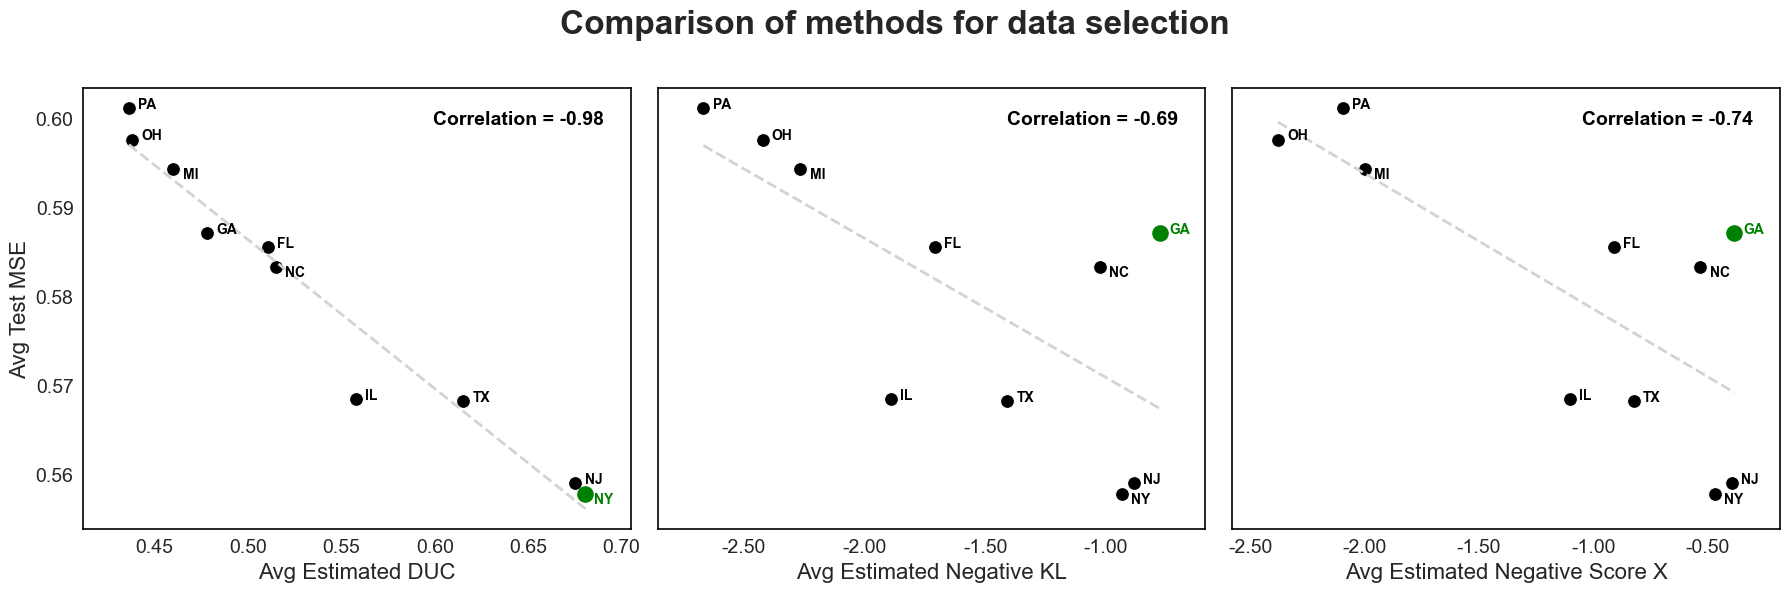

In [9]:
# X-axis columns and labels
x_columns = ['duc', 'neg_kl', 'neg_score_x']
x_labels = [
    'Avg Estimated DUC',
    'Avg Estimated Negative KL',
    'Avg Estimated Negative Score X'
]

# Create subplots: 1 row, 3 columns, share Y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, facecolor='white')

for ax, x_col, x_label in zip(axes, x_columns, x_labels):
    x_min, x_max = results_df[x_col].min(), results_df[x_col].max()
    x_range = x_max - x_min
    ax.tick_params(axis='x', labelsize=14)  
    ax.tick_params(axis='y', labelsize=14) 
    ax.set_xlabel(x_label, fontsize=16)
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # Scatter plot
    sns.scatterplot(
        x=x_col, 
        y='weighted_mse_list', 
        data=results_df, 
        s=100, 
        color='black',
        ax=ax
    )

    max_idx = results_df[x_col].idxmax()

    ax.scatter(
        results_df.loc[max_idx, x_col],
        results_df.loc[max_idx, 'weighted_mse_list'],
        s=120, 
        color='green', 
        zorder=3
    )
    # Regression line
    sns.regplot(
        x=x_col,
        y='weighted_mse_list',
        data=results_df,
        scatter=False,  # don't plot points again
        ax=ax,
        color='blue',
        ci=None,
        line_kws={
        'color': 'lightgrey',
        'linestyle': '--',
        'linewidth': 2
    }
    )

    corr, _ = pearsonr(results_df[x_col], results_df['weighted_mse_list'])

    # Add correlation in top-left corner
    ax.text(
        0.95, 0.95, f'Correlation = {corr:.2f}',
        transform=ax.transAxes,       # relative coordinates
        fontsize=14,
        verticalalignment='top',
        horizontalalignment='right',  # align text to the right
        color='black',
        weight='bold'
    )
    ax.set_facecolor('white') 
    ax.grid(False)

    # Add state labels
    for i in range(results_df.shape[0]):
        color = 'green' if i == max_idx else 'black'
        y_adjustment = 0
        if results_df['state_abbreviation'][i] in ['NY', 'NC', 'MI']:
            y_adjustment = -0.001
        elif results_df['state_abbreviation'][i] == 'OH':
            y_adjustment = +0.0001
        
        ax.text(
            results_df[x_col][i] + 0.02 * x_range,
            results_df['weighted_mse_list'][i] + y_adjustment,
            results_df['state_abbreviation'][i],color=color, weight='semibold'
        )

    # Axis labels
    ax.set_xlabel(x_label)
    ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)

    # Style axis spines
    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.2)

axes[0].set_ylabel('Avg Test MSE', fontsize=16)  

plt.suptitle('Comparison of methods for data selection', fontsize=24, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


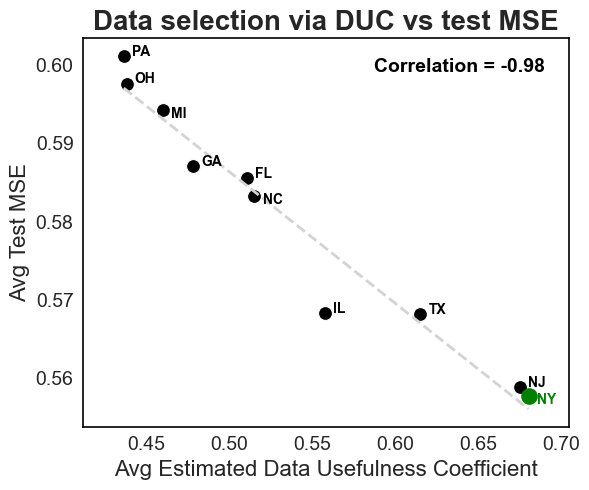

In [10]:
## Just the first plot
x_col = 'duc'
x_label = 'Avg Estimated Data Usefulness Coefficient'

fig, ax = plt.subplots(figsize=(6, 5), facecolor='white')

x_min, x_max = results_df[x_col].min(), results_df[x_col].max()
x_range = x_max - x_min



ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Scatter plot
sns.scatterplot(
    x=x_col, 
    y='weighted_mse_list', 
    data=results_df, 
    s=100, 
    color='black',
    ax=ax
)

# Highlight max point
max_idx = results_df[x_col].idxmax()
ax.scatter(
    results_df.loc[max_idx, x_col],
    results_df.loc[max_idx, 'weighted_mse_list'],
    s=120, 
    color='green', 
    zorder=3
)

# Regression line
sns.regplot(
    x=x_col,
    y='weighted_mse_list',
    data=results_df,
    scatter=False,
    ax=ax,
    color='blue',
    ci=None,
    line_kws={
        'color': 'lightgrey',
        'linestyle': '--',
        'linewidth': 2
    }
)

# Correlation
corr, _ = pearsonr(results_df[x_col], results_df['weighted_mse_list'])
ax.text(
    0.95, 0.95, f'Correlation = {corr:.2f}',
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='right',
    color='black',
    weight='bold'
)

# Add state labels
for i in range(results_df.shape[0]):
    color = 'green' if i == max_idx else 'black'
    y_adjustment = 0
    if results_df['state_abbreviation'][i] in ['NY', 'NC', 'MI']:
        y_adjustment = -0.001
    elif results_df['state_abbreviation'][i] == 'OH':
        y_adjustment = +0.0001

    ax.text(
        results_df[x_col][i] + 0.02 * x_range,
        results_df['weighted_mse_list'][i] + y_adjustment,
        results_df['state_abbreviation'][i],
        color=color, weight='semibold'
    )

ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)

# Style axis spines
for spine in ['left', 'bottom', 'top', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.2)

ax.tick_params(axis='x', labelsize=14)  
ax.tick_params(axis='y', labelsize=14) 
ax.set_xlabel(x_label, fontsize=16)
ax.set_ylabel('Avg Test MSE', fontsize=16)

ax.set_facecolor('white') 
ax.grid(False)

plt.title('Data selection via DUC vs test MSE', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

